<img src="http://oci02.img.iteso.mx/identidad_de_instancia_2018/ITESO/Logos%20ITESO/Logo-ITESO-Principal.jpg">

<center> <font color= #004A94> <font size = 6> Msc Ciencia de datos </font> <br> <br> <font color= #047CFB> <font size = 5>I.F. Juan Francisco Muñoz Elguezabal</font> <br> <br>

<center><font color= #004A94> <font size = 6> ANÁLISIS ESTADÍSTICO MULTIVARIABLE </font> <br>

<center><font color= #42c29b> <font size = 6> Aplicación de modelo PCA en finanzas bursátiles</font> <br> <br> <font color= #047CFB> <font size = 5>Repositorio: <a href='https://github.com/IFFranciscoME/FinTechLab/tree/master/'>Link</a></font>

---

### Cargar librerias

Se cargan las librerias que son necesarias para las funciones dentro del proyecto

In [27]:
import numpy as np                                        # tratamiento cientifico de numeros
import pandas as pd                                       # dataframes
import statsmodels.api as sm                              # modelos estadisticos
from datetime import datetime                             # tratamiento de datetime
from functools import reduce                              # para la union de los dataframes
from os import listdir, getcwd                            # para leer todos los archivos de un folder
from os.path import isfile, join                          # encontrar y unir archivos en un folder
from sklearn.decomposition import PCA                     # principal component analysis
from sklearn import linear_model                          # modelo lineal
from sklearn.model_selection import train_test_split      # separacion de conjunto de entrenamiento y prueba
from statsmodels.formula.api import ols                   # ols
import matplotlib.pyplot as plt                           # plots con matplotlib
from sklearn.preprocessing import MinMaxScaler            # reescalamiento de matriz de datos
import mglearn                                            # visualizacion extra

### Cargar las deependencias

Se cargan las dependencias del proyecto, en este caso son las siguientes:

- **visualizaciones.py** : Donde se encuentran funciones que fueron especialmente ddesarrolladas para visualizar datos en este proyecto.

- **datos.py** : En el cual realiza la función fundamental de contener los parámetros y _token_ para utilizar el servicio de *API* de *OANDA* y solicitar precios históricos, que son regresados en el objeto *pd_hist* cargado finalmente como *precios*. *OANDA* es un *broker* que provee acceso programático a mercados financieros bursátiles de USA, este *broker* convenientemente provee de una **API** o Interfáz Programática de Aplicaciones (por sus siglas en inglés), esto de manera gratuita y con extensa documentación sobre su uso con *python* (mas información al respecto puede ser consultada en su sitio [developer.oanda.com]('http://developer.oanda.com/')

Ambos códigos puede ser encontrardos dentro de la misma carpeta de este proyecto

In [2]:
#import visualizaciones as vs                              # script con funciones para visualizar
from datos import pd_hist as precios                      # importar precios

### Opciones para visualizacion de DataFrame

Se establecen las siguientes opciones para visualizar dataframes en la consola de una manera mas libre

In [3]:
pd.set_option('display.max_rows', None)                   # sin limite de renglones maximos para mostrar pandas
pd.set_option('display.max_columns', None)                # sin limite de columnas maximas para mostrar pandas
pd.set_option('display.width', None)                      # sin limite el ancho del display
pd.set_option('display.expand_frame_repr', False)         # visualizar todas las columnas de un pandas dataframe
pd.options.mode.chained_assignment = None                 # para evitar el warning enfadoso de indexacion

## Planteamiento de la problematica y contexto

Se plantea el reto de modelar el precio semanal del tipo de cambio _Euro Vs Dólar Americano_ , representado por el instrumento financiero de tipo de cambio cruzado con el ticker _EurUsd_. 

- La variable dependiente: **Close** - Precio de cierre semanal del tipo de cambio *EurUsd*
- Las variables independientes o explicativas: **Indicadores macroeconómicos semanales** de las economías de USA y la Zona Euro.

### Calendario Económico

Las variables independientes o explicativas tienen una caracaterística en común, su naturaleza es que son indicadores macroeconómicos que son comunicados regularmente y de manera semanal. Se hizo un compilado de aquellos que se propone tendrán, por razones económicos, justificación de poder ser variables explicativas del tipo de cambio entre ambas economicas. Los indicadores de los que se recabaron históricos de 3 años, son:

| Variable |      Indicador económico     |                        Explicación breve                       |
|:--------:|:----------------------------:|:--------------------------------------------------------------:|
|    x_1   | **3-MonthBillAuction**       | Subasta de deuda soberana de 3 meses de USA.                   |
|    x_2   | **4-WeekBillAuction**        | Subasta de deuda soberana de 4 semanas de USA                  |
|    x_3   | **6-MonthBillAuction**       | Subasta de deuda soberana de 6 meses de USA                    |
|    x_4   | **APIWeeklyCrudeOilStock**   | Inventario semanal de petróleo crudo (API)                     |
|    x_5   | **CFTCEURNCNetPositions**    | CFTC Commitment of Traders en posicions de futuros de Euro     |
|    x_6   | **CFTCGoldNCNetPositions**   | CFTC Commitment of Traders en posicions de futuros de Oro      |
|    x_7   | **CFTCOilNCNetPositions**    | CFTC Commitment of Traders en posicions de futuros de Petróleo |
|    x_8   | **CFTCUSDNCNetPositions**    | CFTC Commitment of Traders en posicions de futuros de Usd      |
|    x_9   | **ContinuingJoblessClaims**  | Peticiones recurrentes de apoyo por desempleo para USA         |
|    x_10  | **EIACrudeOilStockChange**   | Cambio en inventario de petróleo crudo (EIA)                   |
|    x_11  | **EIANaturalGasStockChange** | Cambio en inventario de gas natural (EIA)                      |

La informacion se obtuvo en archivos *csv* de la siguiente fuente [fxstreet/economic_calendar](https://fxstreet.com/economic-calendar/). Para cada uno de los indicadores se descargó un archivo *csv* y se sistematizó su carga, limpieza y acomodo para dejarlos en un *DataFrame* manejable para el modelo

In [4]:
# Obtener el director donde se encuentran todos los archivos
directorio = getcwd() + '/archivos/'

# Obtener una lista de todos los archivos de datos
archivos_ce = [f for f in listdir(directorio) if isfile(join(directorio, f))]


def f_datos_ce(p0_ind):

    # Datos de entrada
    datos = pd.read_csv('archivos/' + p0_ind)

    # Convertir columna de fechas a datetime
    datos['DateTime'] = [datetime.strptime(datos['DateTime'][i], '%m/%d/%Y %H:%M:%S')
                         for i in range(0, len(datos['DateTime']))]

    # Ordernarlos de forma ascendente en el tiempo
    datos.sort_values(by=['DateTime'], inplace=True, ascending=True)
    datos = datos.reset_index(drop=True)

    # Agregar columna con numero de año y semana (Servira para empatar fecha de indicador con fecha de precio)
    datos['Year_Week'] = [datos.loc[i, 'DateTime'].strftime("%Y") + '_' +
                          datos.loc[i, 'DateTime'].strftime("%W") for i in range(0, len(datos['DateTime']))]

    # Solo tomar las columnas para el ejercicio
    datos = datos[['Year_Week', 'Actual']]

    return datos


# Unir dataframes
dataframes = [f_datos_ce(p0_ind=archivos_ce[i]) for i in range(0, len(archivos_ce))]
datos_ce = reduce(lambda left, right: pd.merge(left, right, on=['Year_Week'], how='inner'), dataframes)

# Renombrar las columnas
variables_ce = ['x_' + str(i) for i in range(1, len(archivos_ce)+1)]
datos_ce.columns = ['Year_Week'] + variables_ce

In [5]:
datos_ce.head()

,Year_Week,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11
0,2016_01,0.215,0.200,0.500,-5.6,-160.6,26.6,184.2,-97.2,2.230,-5.085,-113
1,2016_02,0.215,0.220,0.470,-3.9,-146.5,44.7,163.5,-162.3,2.263,0.234,-168
2,2016_03,0.255,0.250,0.370,4.6,-137.0,43.7,179.4,-188.5,2.208,3.979,-178
3,2016_04,0.305,0.295,0.415,11.4,-127.2,59.0,205.7,-131.9,2.268,8.383,-211
4,2016_05,0.350,0.270,0.465,3.8,-87.1,72.8,196.9,-225.9,2.255,7.792,-152


### Precios de OANDA

Se descargaron los precios *OHLC* del instrumento *EurUsd*, se utilizó para el modelo sólamente el precio de *Apertura* (Open) y el de *Cierre* (Close). Con información de los últimos 3 años.Los detalles de este proceso se pueden verificar en el script *datos.py*

In [6]:
# Generacion de variables explicativas
datos_fx = precios[['TimeStamp', 'Close', 'Open']]

# Convertir a valor tipo float
datos_fx.loc[:, 'Close'] = datos_fx.loc[:, 'Close'].astype(float)
datos_fx.loc[:, 'Open'] = datos_fx.loc[:, 'Open'].astype(float)

# Calcular el rendimiento logaritmico como variable a explicar Y
datos_fx.loc[:, 'log_ret'] = np.log(datos_fx.loc[:, 'Close']/datos_fx.loc[:, 'Close'].shift(1))

# Calcular la diferencia entre precio de cierre y apertura multiplicado por el multiplicador (PIP)
datos_fx.loc[:, 'pips_co'] = (datos_fx.loc[:, 'Close'] - datos_fx.loc[:, 'Open'])*10000

# Eliminar el NaN inicial
datos_fx = datos_fx.dropna()

# Resetear index de data frame
datos_fx = datos_fx.reset_index(drop=True)

# Convertir columna de fechas a datetime
datos_fx['TimeStamp'] = pd.to_datetime(datos_fx['TimeStamp'])

# Agregar columna de semana
# datos_fx['Semana'] = [datos_fx.loc[i, 'TimeStamp'].strftime("%W") for i in range(0, len(datos_fx['TimeStamp']))]
datos_fx['Year_Week'] = [datos_fx.loc[i, 'TimeStamp'].strftime("%Y") + '_' +
                         datos_fx.loc[i, 'TimeStamp'].strftime("%W") for i in range(0, len(datos_fx['TimeStamp']))]

In [7]:
datos_fx.head()

,TimeStamp,Close,Open,log_ret,pips_co,Year_Week
0,2016-01-08 21:00:00,1.09174,1.09194,-0.000183,-2.0,2016_01
1,2016-01-15 21:00:00,1.07967,1.09170,-0.011117,-120.3,2016_02
2,2016-01-22 21:00:00,1.08334,1.07970,0.003393,36.4,2016_03
3,2016-01-29 21:00:00,1.11530,1.08336,0.029075,319.4,2016_04
4,2016-02-05 21:00:00,1.12546,1.11534,0.009068,101.2,2016_05


### Union de datos en un solo DataFrame

La union entre los DataFrame de: *datos_ce* y *datos_fx* se hará mediante la columna de *Year_Week*.

In [8]:
# unir los dos dataframes para obtener el dataframe a usar en el modelo
datos_md = pd.merge(datos_fx, datos_ce, on=['Year_Week'], how='inner')

# eliminar la columna Year_Week
datos_md = datos_md.drop(['Year_Week'], axis=1)

In [9]:
datos_md.head()

,TimeStamp,Close,Open,log_ret,pips_co,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11
0,2016-01-08 21:00:00,1.09174,1.09194,-0.000183,-2.0,0.215,0.200,0.500,-5.6,-160.6,26.6,184.2,-97.2,2.230,-5.085,-113
1,2016-01-15 21:00:00,1.07967,1.09170,-0.011117,-120.3,0.215,0.220,0.470,-3.9,-146.5,44.7,163.5,-162.3,2.263,0.234,-168
2,2016-01-22 21:00:00,1.08334,1.07970,0.003393,36.4,0.255,0.250,0.370,4.6,-137.0,43.7,179.4,-188.5,2.208,3.979,-178
3,2016-01-29 21:00:00,1.11530,1.08336,0.029075,319.4,0.305,0.295,0.415,11.4,-127.2,59.0,205.7,-131.9,2.268,8.383,-211
4,2016-02-05 21:00:00,1.12546,1.11534,0.009068,101.2,0.350,0.270,0.465,3.8,-87.1,72.8,196.9,-225.9,2.255,7.792,-152


### Analisis de Componentes Principales

Se buscará analizar los componentes principales en las variables exógenas que se propusieron anteriormente.

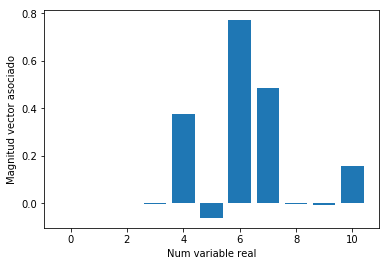

In [22]:
pca = PCA(n_components=4)
datos_pca = datos_md.iloc[:, 5:]
pca.fit(datos_pca)
transformada = pca.transform(datos_pca)
# mglearn.discrete_scatter(transformada[:, 1], transformada[:, 2])
# plt.xlabel('PCA 1')
# plt.ylabel('PCA 2')
# plt.show()

# comprobar dimensiones maximas para reducir
w, v = np.linalg.eig(pca.get_covariance())  # Calcular los vectores y valores propios de la martiz de covarianza
indx = np.argsort(w)[::-1]  # ordenar los valores de mayor a menor
porcentaje = w[indx]/np.sum(w)  # calcular el procentaje de varianza en cada componente
porcent_acum = np.cumsum(porcentaje)  # calcular el porcentaje acumulado de los componentes
pca_90 = np.where(porcent_acum > 0.9)[0][0] + 1
pca_90

matrix_transform = pca.components_.T

plt.bar(np.arange(len(matrix_transform)), matrix_transform[:, 0])
plt.xlabel('Num variable real')
plt.ylabel('Magnitud vector asociado')
plt.show()


In [23]:
# comprobar dimensiones maximas para reducir
w, v = np.linalg.eig(pca.get_covariance())  # Calcular los vectores y valores propios de la martiz de covarianza
indx = np.argsort(w)[::-1]  # ordenar los valores de mayor a menor
porcentaje = w[indx]/np.sum(w)  # calcular el procentaje de varianza en cada componente
porcent_acum = np.cumsum(porcentaje)  # calcular el porcentaje acumulado de los componentes
pca_90 = np.where(porcent_acum > 0.9)[0][0] + 1
print('la cantidad de componentes necesarias para obtener un 90% de explicaciones es: ' + str(pca_90))

la cantidad de componentes necesarias para obtener un 90% de explicaciones es: 4


In [26]:
porcent_acum

array([0.54480634, 0.73343578, 0.87921217, 0.96901274, 0.97343949,
       0.97786624, 0.98229299, 0.98671974, 0.9911465 , 0.99557325,
       1.        ])

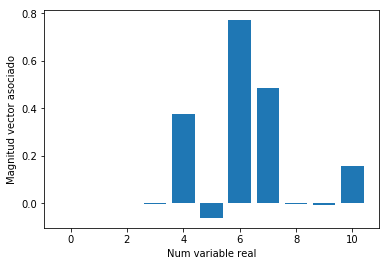

In [24]:
# mglearn.discrete_scatter(transformada[:, 1], transformada[:, 2])
# plt.xlabel('PCA 1')
# plt.ylabel('PCA 2')
# plt.show()
matrix_transform = pca.components_.T
plt.bar(np.arange(len(matrix_transform)), matrix_transform[:, 0])
plt.xlabel('Num variable real')
plt.ylabel('Magnitud vector asociado')
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


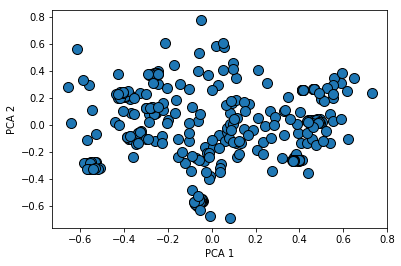

In [25]:
escala=MinMaxScaler()
escala.fit(datos_pca)
escalada=escala.transform(datos_pca)
pca.fit(escalada)
transformada=pca.transform(escalada)
mglearn.discrete_scatter(transformada[:,1],transformada[:,2])
plt.gca()
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()